<h1>Data Exploration</h1>

In [1]:
import os
parentdir = "propaganda_dataset_v2"
train_file = "propaganda_train.tsv"
val_file = "propaganda_val.tsv"
train_path = os.path.join(parentdir,train_file)
val_path = os.path.join(parentdir,val_file)

In [2]:
import pandas as pd
train_df = pd.read_csv(train_path,delimiter="\t",quotechar='|')
train_df.head(10)

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
6,not_propaganda,A federal judge on Monday ordered U.S. immigra...
7,not_propaganda,<BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...
8,doubt,"As noted above, at this point literally every ..."
9,not_propaganda,Britain doesn't need more hate even just for a...


In [3]:
train_df[train_df["label"] == "not_propaganda"].head(10)

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
6,not_propaganda,A federal judge on Monday ordered U.S. immigra...
7,not_propaganda,<BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...
9,not_propaganda,Britain doesn't need more hate even just for a...
11,not_propaganda,"Ironically, even in doing this he is <BOS> lik..."
13,not_propaganda,During the term of the Assassination <BOS> Rec...
15,not_propaganda,President Trump ordered that the relevant docu...


In [4]:
val_df=pd.read_csv(val_path, delimiter='\t', quotechar='|')

In [5]:
print(f'train df has {len(train_df)} items')
print(f'val df has {len(val_df)} items')

train df has 2560 items
val df has 640 items


<h1>Sentence-Level Binary Classification</h1>

<h2>Preprocessing</h2>

In [6]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Convert labels to binary depending on whether they contain propaganda or not

In [7]:
bin_df = train_df.copy()  # Make a copy to turn labels to binary
prop_classes = train_df["label"].unique()  # Get all unique labels in df
for prop_class in prop_classes:  # Iterate through unique classes
    if prop_class != "not_propaganda":  # Convert "not_propaganda" to 0 and all "propaganda" labels to 1
        bin_df.loc[bin_df["label"] == prop_class, "label"] = 1
    else:
        bin_df.loc[bin_df["label"] == prop_class, "label"] = 0
bin_df.head(10)

,label,tagged_in_context
0,0,"No, <BOS> he <EOS> will not be confirmed."
1,0,This declassification effort <BOS> won’t make ...
2,1,"""The Obama administration misled the <BOS> Ame..."
3,0,“It looks like we’re capturing the demise of t...
4,0,"<BOS> Location: Westerville, Ohio <EOS>"
5,1,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
6,0,A federal judge on Monday ordered U.S. immigra...
7,0,<BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...
8,1,"As noted above, at this point literally every ..."
9,0,Britain doesn't need more hate even just for a...


In [8]:
bin_val_df = val_df.copy()  # Validation dataframe, same binarization method as training
prop_classes = val_df["label"].unique()
for prop_class in prop_classes:
    if prop_class != "not_propaganda":
        bin_val_df.loc[bin_val_df["label"] == prop_class, "label"] = 1
    else:
        bin_val_df.loc[bin_val_df["label"] == prop_class, "label"] = 0

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brxce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
texts = bin_df["tagged_in_context"].tolist()  # Convert the texts to a list
texts = [sub.replace("<BOS>","") for sub in texts]  # Remove the snippet tags from the text
texts = [sub.replace("<EOS>","") for sub in texts]
labels = bin_df["label"].tolist()  # Convert labels to a list

In [11]:
valtexts = bin_val_df["tagged_in_context"].tolist()  # Same as training set
valtexts = [sub.replace("<BOS>","") for sub in valtexts]
valtexts = [sub.replace("<EOS>","") for sub in valtexts]
vallabels = bin_val_df["label"].tolist()

In [12]:
stop_words = set(stopwords.words('english'))

In [15]:
def preprocess(texts, stopword_removal = False, punctuation_removal = False):
    if punctuation_removal:  # Remove punctuation from the text
        tokenizer = RegexpTokenizer(r'\w+')
        text_prep = [tokenizer.tokenize(text) for text in texts]
    else:  # Tokenize the sentence without punctuation removal
        text_prep = [word_tokenize(text) for text in texts]
        
    if stopword_removal:  # Remove stopwords
            text_prep = [[w for w in sentence if not w.lower() in stop_words] for sentence in text_prep]
        
    text_prep = [" ".join(sentence) for sentence in text_prep]
    return text_prep

<h2>Bag of Words Classifier</h2>

In [16]:
def bow_classify(train_texts, train_labels, val_texts, val_labels , max_features=5000, ngram=(1,1)):
    
    vectorizer = CountVectorizer(max_features = max_features, ngram_range=ngram)
    vectorizer.fit(train_texts)  # Convert texts into a bag-of-words representation
    Xvectors = vectorizer.transform(train_texts)

    classifier = MultinomialNB()
    classifier.fit(Xvectors, train_labels)  # Fit the bag-of-words to a Multinomial Naive Bayes classifier

    testVectors = vectorizer.transform(val_texts)
    pred = classifier.predict(testVectors)  # Predict validation texts with Multinomial NB

    acc = accuracy_score(val_labels, pred)
    rep = classification_report(val_labels, pred)  # classifier report
    cm = confusion_matrix(val_labels, pred)
    return acc, rep, cm

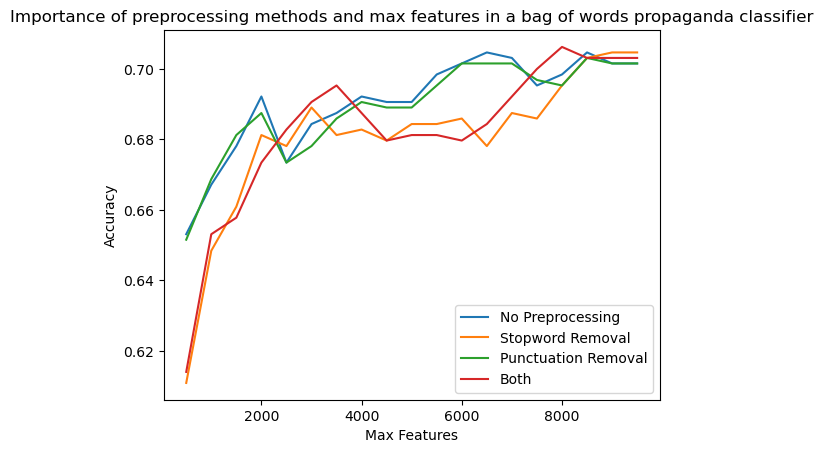

In [17]:
# No preprocessing set
text_noprep = preprocess(texts, stopword_removal = False, punctuation_removal = False)
val_noprep = preprocess(valtexts, stopword_removal = False, punctuation_removal = False)
noprep_accuracies = []

# Stop word removal set
text_swr = preprocess(texts, stopword_removal = True, punctuation_removal = False)
val_swr = preprocess(valtexts, stopword_removal = True, punctuation_removal = False)
swr_accuracies = []

# Punctuation removal set
text_pr = preprocess(texts, stopword_removal = False, punctuation_removal = True)
val_pr = preprocess(valtexts, stopword_removal = False, punctuation_removal = True)
pr_accuracies = []

# Both stop word and punctuation removal set
text_prep = preprocess(texts, stopword_removal = True, punctuation_removal = True)
val_prep = preprocess(valtexts, stopword_removal = True, punctuation_removal = True)
prep_accuracies = []

t = []  # Value for x axis
for mf in range(500, 10000, 500):  # Iterate through a range of max feature parameters
    # Classify with no preprocessing
    acc, _, _ = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=mf)
    noprep_accuracies.append(acc)

    # Classify with stopword removal
    acc, _, _ = bow_classify(text_swr, labels, val_swr, vallabels, max_features=mf)
    swr_accuracies.append(acc)

    # Classify with punctuation removal
    acc, _, _ = bow_classify(text_pr, labels, val_pr, vallabels, max_features=mf)
    pr_accuracies.append(acc)

    # Classify with both preprocessing
    acc, _, _ = bow_classify(text_prep, labels, val_prep, vallabels, max_features=mf)
    prep_accuracies.append(acc)

    t.append(mf) # Append max feature value to x axis array

# Plot graph
plt.plot(t, noprep_accuracies, label='No Preprocessing')
plt.plot(t, swr_accuracies, label='Stopword Removal')
plt.plot(t, pr_accuracies, label='Punctuation Removal')
plt.plot(t, prep_accuracies, label='Both')
plt.legend(loc='lower right')
plt.xlabel("Max Features")
plt.ylabel("Accuracy")
plt.title("Importance of preprocessing methods and max features in a bag of words propaganda classifier")
plt.show()

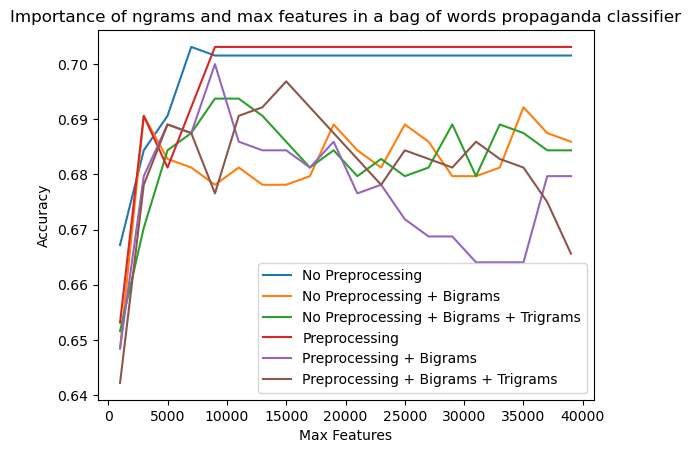

In [22]:
noprep_accuracies = []
noprep_bigram_accuracies = []
noprep_trigram_accuracies = []
prep_accuracies = []
prep_bigram_accuracies = []
prep_trigram_accuracies = []
t = []

for mf in range(1000, 40000, 2000):
    # Unigrams, no preprocessing
    acc, _, _ = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=mf)
    noprep_accuracies.append(acc)

    # Bigrams, no preprocessing
    acc, _, _ = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=mf, ngram=(1,2))
    noprep_bigram_accuracies.append(acc)

    # Trigrams, no preprocessing
    acc, _, _ = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=mf, ngram=(1,3))
    noprep_trigram_accuracies.append(acc)

    # Unigrams, preprocessing
    acc, _, _ = bow_classify(text_prep, labels, val_prep, vallabels, max_features=mf)
    prep_accuracies.append(acc)

    # Bigrams, preprocessing
    acc, _, _ = bow_classify(text_prep, labels, val_prep, vallabels, max_features=mf, ngram=(1,2))
    prep_bigram_accuracies.append(acc)

    # Trigrams, preprocessing
    acc, _, _ = bow_classify(text_prep, labels, val_prep, vallabels, max_features=mf, ngram=(1,3))
    prep_trigram_accuracies.append(acc)
    t.append(mf)

plt.plot(t, noprep_accuracies, label='No Preprocessing')
plt.plot(t, noprep_bigram_accuracies, label='No Preprocessing + Bigrams')
plt.plot(t, noprep_trigram_accuracies, label='No Preprocessing + Bigrams + Trigrams')
plt.plot(t, prep_accuracies, label='Preprocessing')
plt.plot(t, prep_bigram_accuracies, label='Preprocessing + Bigrams')
plt.plot(t, prep_trigram_accuracies, label='Preprocessing + Bigrams + Trigrams')
plt.legend(loc='lower right')
plt.xlabel("Max Features")
plt.ylabel("Accuracy")
plt.title("Importance of ngrams and max features in a bag of words propaganda classifier")
plt.show()

In [23]:
mf = 8000
def feature_importance(train_texts, train_labels, val_texts, val_labels , max_features=5000, ngram=1):
    
    vectorizer = CountVectorizer(max_features = max_features, ngram_range=(ngram, ngram))
    vectorizer.fit(train_texts)
    Xvectors = vectorizer.transform(train_texts)

    classifier = MultinomialNB()
    classifier.fit(Xvectors, train_labels)

    testVectors = vectorizer.transform(val_texts)
    pred = classifier.predict(testVectors)
    
    neg_class_prob_sorted = classifier.feature_log_prob_[0, :].argsort()[::-1]
    pos_class_prob_sorted = classifier.feature_log_prob_[1, :].argsort()[::-1]

    print(np.take(vectorizer.get_feature_names_out(), neg_class_prob_sorted[:10]))
    print(np.take(vectorizer.get_feature_names_out(), pos_class_prob_sorted[:10]))

In [24]:
feature_importance(text_prep, labels, val_prep, vallabels, max_features=8000)
feature_importance(text_swr, labels, val_prep, vallabels, max_features=8000)
feature_importance(text_noprep, labels, val_noprep, vallabels, max_features=8000)

['said' 'one' 'trump' 'would' 'also' 'pope' 'church' 'president' 'new'
 'people']
['people' 'trump' 'one' 'said' 'church' 'would' 'american' 'us' 'many'
 'even']
['said' 'one' 'trump' 'would' 'also' 'pope' 'church' 'president' 'new'
 'people']
['people' 'trump' 'one' 'said' 'church' 'would' 'american' 'many' 'us'
 'even']
['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'was' 'with']
['the' 'to' 'of' 'and' 'that' 'in' 'is' 'it' 'as' 'for']


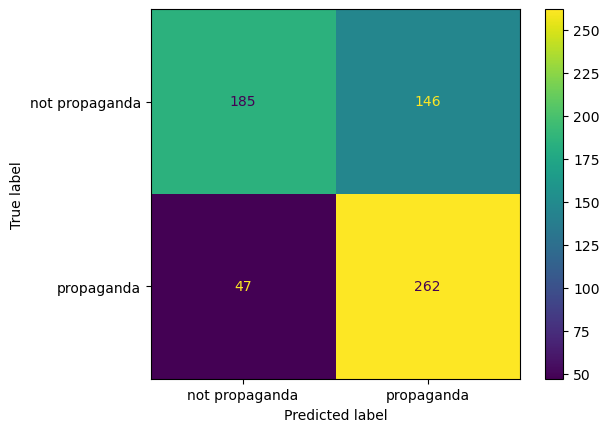

In [25]:
acc, rep, cm = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=8000)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['not propaganda', 'propaganda'])
disp.plot()

In [27]:
print(rep)

              precision    recall  f1-score   support

           0       0.80      0.56      0.66       331
           1       0.64      0.85      0.73       309

    accuracy                           0.70       640
   macro avg       0.72      0.70      0.69       640
weighted avg       0.72      0.70      0.69       640



<h2>BERT Classifier</h2>

In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#texts = train_df["tagged_in_context"].tolist()
#texts = [sub.replace("<BOS>","") for sub in texts]
#texts = [sub.replace("<EOS>","") for sub in texts]

#labels = bin_df["label"].tolist()

In [30]:
# Prepare input for BERT
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [42]:
# Define the classifier
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [85]:
# Train the classifier
def train(model, train_loader, val_loader, optimizer, scheduler, device):
    train_losses = []
    val_losses = []
    accuracies = []
    model.train()
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 8 == 1:
            train_losses.append(loss.detach().item())
            actual_labels, predictions, val_loss, _ = evaluate(model, val_loader, device)
            accuracies.append(accuracy_score(actual_labels, predictions))
            val_losses.append(val_loss)
    return train_losses, val_losses, accuracies

In [86]:
# Evaluate the classifier
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    val_losses = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            val_losses.append(loss.detach().item())
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return actual_labels, predictions, sum(val_losses)/len(val_losses), classification_report(actual_labels, predictions)

In [87]:
# Predict the class of a given input
def predict_sentiment(text, model, tokenizer, device, max_length='128'):
    model.eval()
    encoding=tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "positive" if preds.item() == 1 else "negative"

In [88]:
# Hyperparameters, etc.
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 32
num_epochs = 3
learning_rate = 2e-5

In [89]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42) # Split the model into training and validation set
# Use the validation data from the BoW classifier as test data for BERT
test_texts = valtexts
test_labels = vallabels

In [90]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)  # Tokenize the model using pretrained bert tokenizer
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [91]:
# Use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [92]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
warmup_steps = round(total_steps/10)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [93]:
train_losses = []
val_losses = []
accuracies = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, val_loss, accuracy = train(model, train_dataloader, val_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    accuracies.append(accuracy)
    val_losses.append(val_loss)
    #print(f"Validation accuracy: {accuracy[-1]:.4f}")
    #print(report)

Epoch 1/3
Epoch 2/3
Epoch 3/3


In [95]:
train_losses = [item for row in train_losses for item in row]
val_losses = [item for row in val_losses for item in row]
accuracies = [item for row in accuracies for item in row]

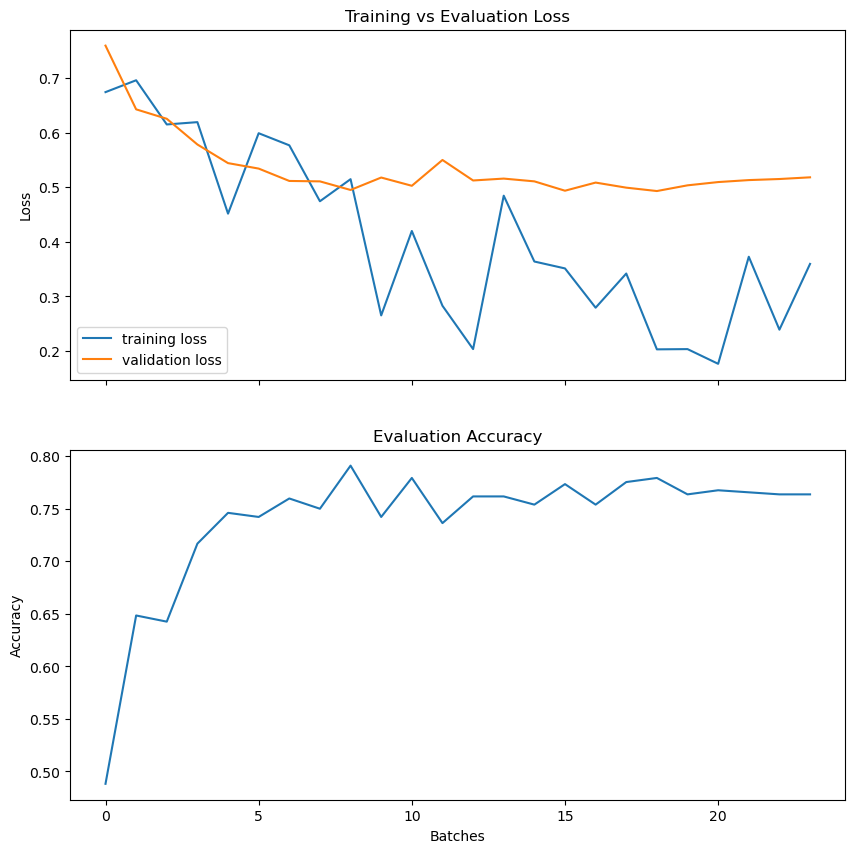

In [96]:
# Plot graph

fig, axs = plt.subplots(2, sharex=True, figsize=(10,10))
x = range(len(train_losses))
axs[0].set_title("Training vs Evaluation Loss")
axs[1].set_title("Evaluation Accuracy")
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Batches")
axs[0].plot(x, train_losses, label="training loss")
axs[0].plot(x, val_losses, label="validation loss")
axs[1].plot(x, accuracies)
axs[0].legend(loc='lower left')
plt.show()

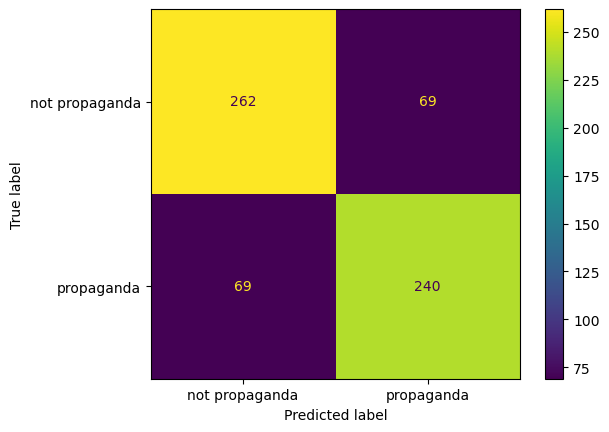

In [97]:
actual_labels, predictions, _, _ = evaluate(model, test_dataloader, device)
cm = confusion_matrix(actual_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['not propaganda', 'propaganda'])
disp.plot()

In [98]:
rep = classification_report(actual_labels, predictions)
print(rep)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       331
           1       0.78      0.78      0.78       309

    accuracy                           0.78       640
   macro avg       0.78      0.78      0.78       640
weighted avg       0.78      0.78      0.78       640



<h1>Snippet Propaganda Technique Classification</h1>

<h2>Preprocessing</h2>

In [100]:
classes = ["flag_waving",
           "appeal_to_fear_prejudice",
           "causal_oversimplification",
           "doubt",
           "exaggeration,minimisation",
           "loaded_language",
           "name_calling,labeling",
           "repetition"]

In [101]:
classes.index("repetition")

7

In [102]:
snip_df = train_df.copy()
snip_df = snip_df[snip_df.label != 'not_propaganda']
prop_classes = snip_df["label"].unique()
for prop_class in prop_classes:
    snip_df.loc[snip_df["label"] == prop_class, "label"] = classes.index(prop_class)
snip_df.head(10)

,label,tagged_in_context
2,0,"""The Obama administration misled the <BOS> Ame..."
5,5,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
8,3,"As noted above, at this point literally every ..."
10,6,His account was suspended for violating Twitte...
12,1,A couple of seemingly unrelated events this pa...
14,7,Trump has expelled <BOS> more <EOS> Russian di...
18,3,<BOS> But who authorized this strategic commit...
19,2,"Outside of specialists and seekers, <BOS> the ..."
20,3,<BOS> We must ask ourselves why this hasn’t ha...
21,5,We’ve caught on to his <BOS> sneaky <EOS> syno...


In [103]:
snip_val_df = val_df.copy()
snip_val_df = snip_val_df[snip_val_df.label != 'not_propaganda']
prop_classes = snip_val_df["label"].unique()
for prop_class in prop_classes:
    snip_val_df.loc[snip_val_df["label"] == prop_class, "label"] = classes.index(prop_class)

In [104]:
texts = snip_df["tagged_in_context"].tolist()
texts = [s[s.index("<BOS>")+6:s.index("<EOS>")-1] for s in texts]
labels = snip_df["label"].tolist()

In [105]:
valtexts = snip_val_df["tagged_in_context"].tolist()
valtexts = [s[s.index("<BOS>")+6:s.index("<EOS>")-1] for s in valtexts]
vallabels = snip_val_df["label"].tolist()

<h2>Bag of Words</h2>

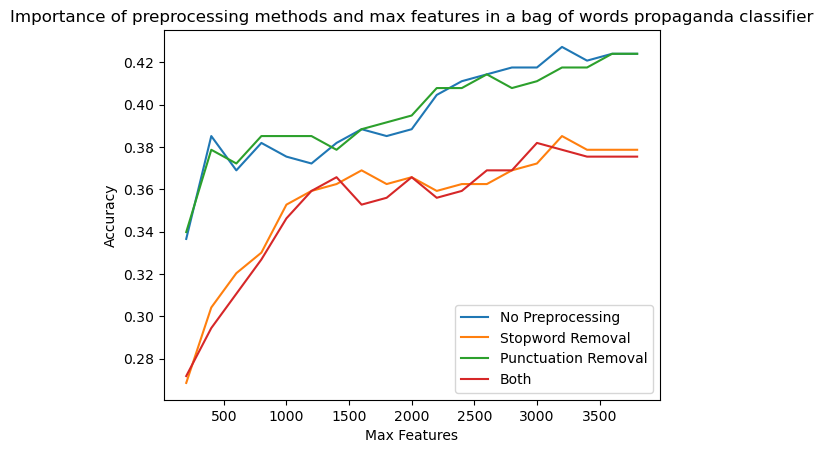

In [106]:
text_noprep = preprocess(texts, stopword_removal = False, punctuation_removal = False)
val_noprep = preprocess(valtexts, stopword_removal = False, punctuation_removal = False)
noprep_accuracies = []
text_swr = preprocess(texts, stopword_removal = True, punctuation_removal = False)
val_swr = preprocess(valtexts, stopword_removal = True, punctuation_removal = False)
swr_accuracies = []
text_pr = preprocess(texts, stopword_removal = False, punctuation_removal = True)
val_pr = preprocess(valtexts, stopword_removal = False, punctuation_removal = True)
pr_accuracies = []
text_prep = preprocess(texts, stopword_removal = True, punctuation_removal = True)
val_prep = preprocess(valtexts, stopword_removal = True, punctuation_removal = True)
prep_accuracies = []
t = []
for mf in range(200, 4000, 200):
    acc, _, _ = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=mf)
    noprep_accuracies.append(acc)
    acc, _, _ = bow_classify(text_swr, labels, val_swr, vallabels, max_features=mf)
    swr_accuracies.append(acc)
    acc, _, _ = bow_classify(text_pr, labels, val_pr, vallabels, max_features=mf)
    pr_accuracies.append(acc)
    acc, _, _ = bow_classify(text_prep, labels, val_prep, vallabels, max_features=mf)
    prep_accuracies.append(acc)
    t.append(mf)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()
plt.plot(t, noprep_accuracies, label='No Preprocessing')
plt.plot(t, swr_accuracies, label='Stopword Removal')
plt.plot(t, pr_accuracies, label='Punctuation Removal')
plt.plot(t, prep_accuracies, label='Both')
plt.legend(loc='lower right')
plt.xlabel("Max Features")
plt.ylabel("Accuracy")
plt.title("Importance of preprocessing methods and max features in a bag of words propaganda classifier")
plt.show()

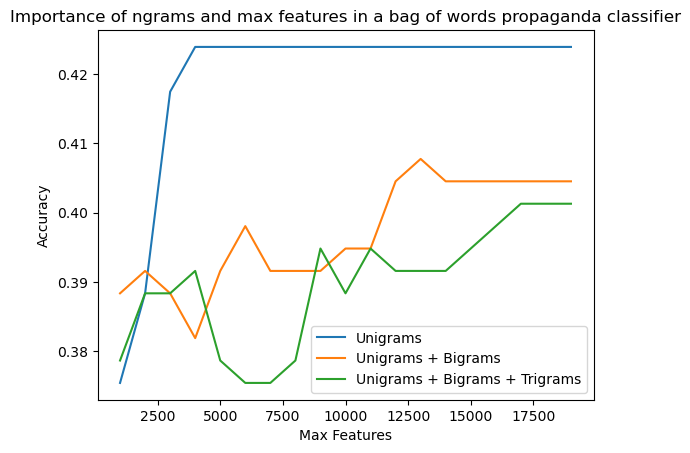

In [107]:
text_noprep = preprocess(texts, stopword_removal = False, punctuation_removal = False)
val_noprep = preprocess(valtexts)
noprep_accuracies = []
noprep_bigram_accuracies = []
noprep_trigram_accuracies = []
t = []
for mf in range(1000, 20000, 1000):
    acc, _, _ = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=mf)
    noprep_accuracies.append(acc)
    acc, _, _ = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=mf, ngram=(1,2))
    noprep_bigram_accuracies.append(acc)
    acc, _, _ = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=mf, ngram=(1,3))
    noprep_trigram_accuracies.append(acc)
    acc, _, _ = bow_classify(text_prep, labels, val_prep, vallabels, max_features=mf)
    t.append(mf)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()
plt.plot(t, noprep_accuracies, label='Unigrams')
plt.plot(t, noprep_bigram_accuracies, label='Unigrams + Bigrams')
plt.plot(t, noprep_trigram_accuracies, label='Unigrams + Bigrams + Trigrams')
plt.legend(loc='lower right')
plt.xlabel("Max Features")
plt.ylabel("Accuracy")
plt.title("Importance of ngrams and max features in a bag of words propaganda classifier")
plt.show()

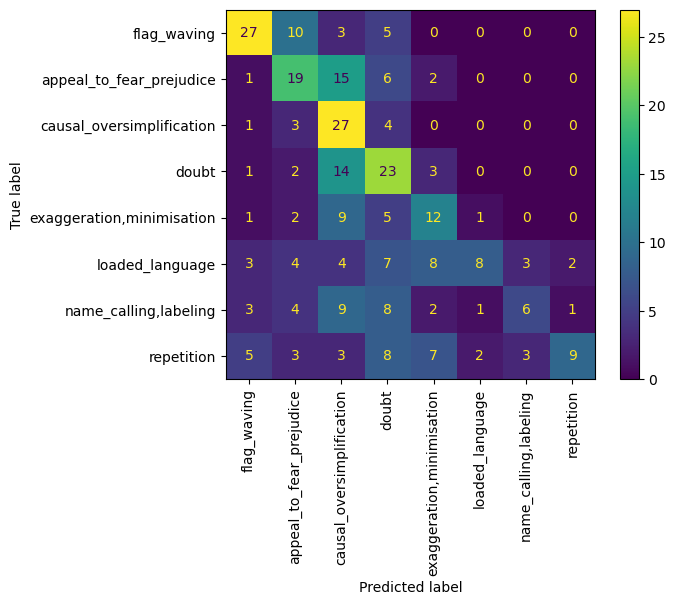

In [108]:
acc, rep, cm = bow_classify(text_noprep, labels, val_noprep, vallabels, max_features=4000)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classes)
disp.plot(xticks_rotation=90)

In [125]:
print(rep)

              precision    recall  f1-score   support

           0       0.64      0.60      0.62        45
           1       0.40      0.44      0.42        43
           2       0.32      0.77      0.45        35
           3       0.35      0.53      0.42        43
           4       0.35      0.40      0.38        30
           5       0.67      0.21      0.31        39
           6       0.50      0.18      0.26        34
           7       0.75      0.23      0.35        40

    accuracy                           0.42       309
   macro avg       0.50      0.42      0.40       309
weighted avg       0.51      0.42      0.41       309



<h2>BERT Classifier</h2>

In [123]:
# Hyperparameters, etc.
bert_model_name = 'bert-base-uncased'
num_classes = 8
max_length = 128
batch_size = 32
num_epochs = 6
learning_rate = 2e-5

In [124]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42) # Split the model into training and validation set
# Use the validation data from the BoW classifier as test data for BERT
test_texts = valtexts
test_labels = vallabels

In [125]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)  # Tokenize the model using pretrained bert tokenizer
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [126]:
# Use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [127]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
warmup_steps = round(total_steps/10)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [128]:
train_losses = []
val_losses = []
accuracies = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, val_loss, accuracy = train(model, train_dataloader, val_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    accuracies.append(accuracy)
    val_losses.append(val_loss)
    #print(f"Validation accuracy: {accuracy[-1]:.4f}")
    #print(report)

Epoch 1/6


C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Epoch 2/6


C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\brxce\anaconda3\envs\NeuralNetworks\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Epoch 3/6
Epoch 4/6
Epoch 5/6
Epoch 6/6


In [129]:
train_losses = [item for row in train_losses for item in row]
val_losses = [item for row in val_losses for item in row]
accuracies = [item for row in accuracies for item in row]

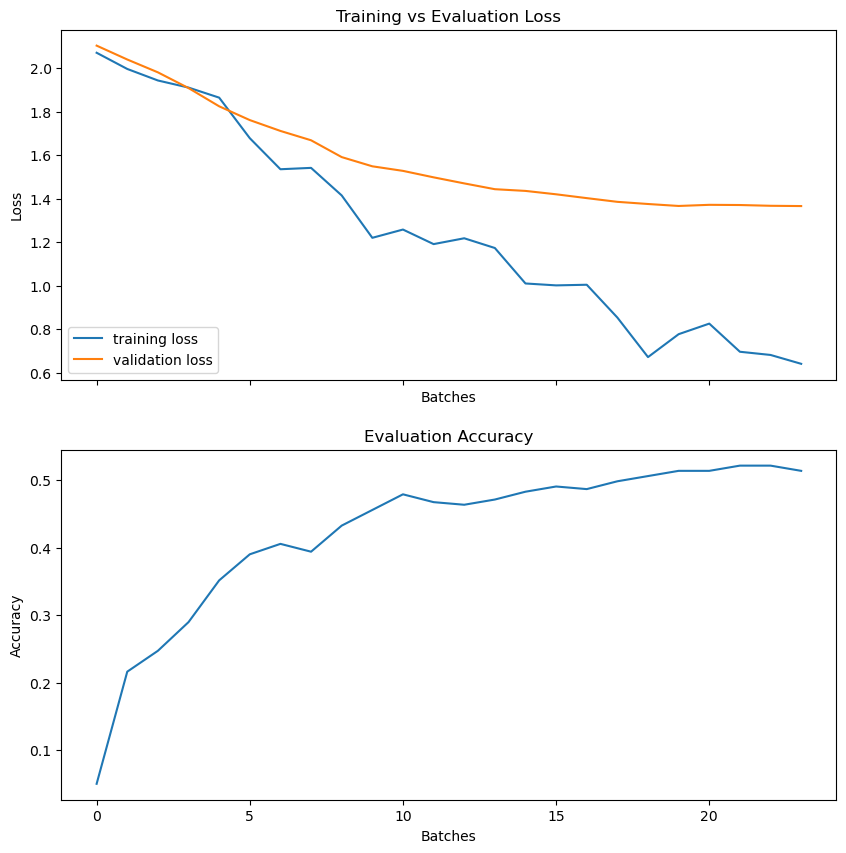

In [131]:
# Plot graph

fig, axs = plt.subplots(2, sharex=True, figsize=(10,10))
x = range(len(train_losses))
axs[0].set_title("Training vs Evaluation Loss")
axs[1].set_title("Evaluation Accuracy")
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Batches")
axs[0].set_xlabel("Batches")
axs[0].plot(x, train_losses, label="training loss")
axs[0].plot(x, val_losses, label="validation loss")
axs[1].plot(x, accuracies)
axs[0].legend(loc='lower left')
plt.show()

In [133]:
actual_labels, predictions, _, _ = evaluate(model, test_dataloader, device)

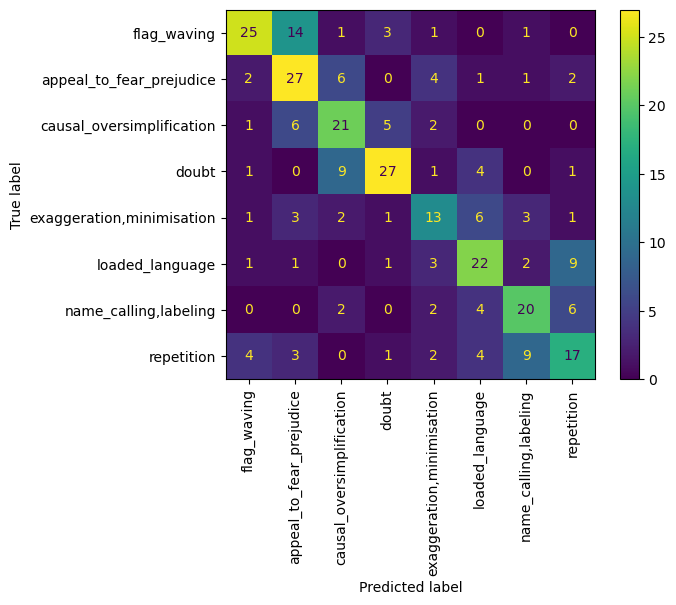

In [134]:
cm = confusion_matrix(actual_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classes)
disp.plot(xticks_rotation=90)

In [135]:
rep = classification_report(actual_labels, predictions)
print(rep)

              precision    recall  f1-score   support

           0       0.71      0.56      0.62        45
           1       0.50      0.63      0.56        43
           2       0.51      0.60      0.55        35
           3       0.71      0.63      0.67        43
           4       0.46      0.43      0.45        30
           5       0.54      0.56      0.55        39
           6       0.56      0.59      0.57        34
           7       0.47      0.42      0.45        40

    accuracy                           0.56       309
   macro avg       0.56      0.55      0.55       309
weighted avg       0.57      0.56      0.56       309

